In [49]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import polars as pl
from jetutils.definitions import DATADIR, xarray_to_polars
from jetutils.data import standardize
import scoringrules as sr
import colormaps
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [3]:
basepath = Path(DATADIR, "S2S", "surf")
ref = standardize(xr.open_dataarray(basepath.joinpath("mslp_era5/daily/full.nc")))

In [71]:
means = {}
for f in basepath.joinpath("mslp_fct/daily").glob("*.nc"):
    fct = standardize(xr.open_dataarray(f))
    ref_ = ref.sel(time=fct["time"])
    score = ref_.copy(data=sr.crps_ensemble(ref_, fct.transpose("time", "lat", "lon", "number")))
    score = xarray_to_polars(score)
    means[f.stem] = score.group_by("time", maintain_order=True).agg(pl.col("msl").mean()).with_columns(dt=(pl.col("time") - pl.col("time").first().over(pl.col("time").dt.year())) / pl.duration(days=1)).group_by("dt", maintain_order=True).agg(pl.col("msl").mean())

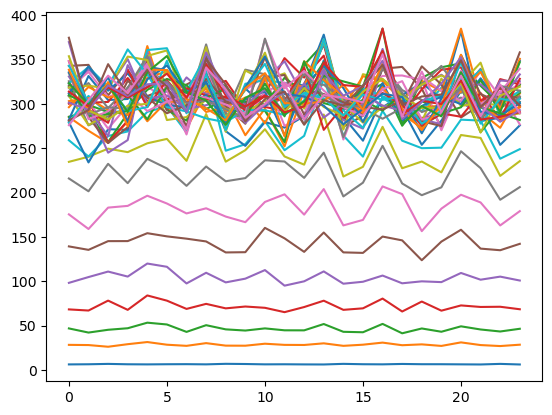

In [72]:
for dt, huh in pl.concat([means_.with_columns(date=pl.lit(date)) for date, means_ in means.items()]).with_columns(pl.col("date").rle_id()).group_by("dt", maintain_order=True):
    plt.plot(huh["date"], huh["msl"])


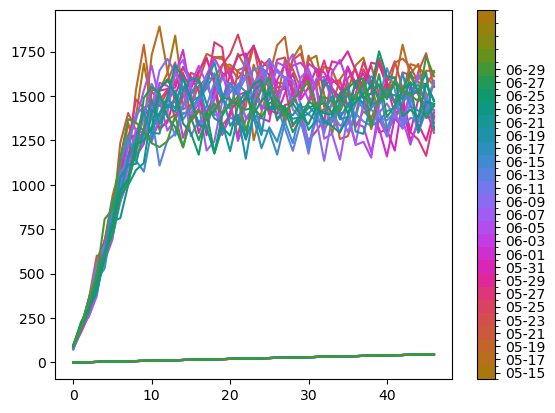

In [64]:
a = list(means)
a.sort()
cmap = colormaps.phase
norm = BoundaryNorm(np.arange(len(a) + 5) - 0.5, cmap.N)
colors = cmap(norm(np.arange(len(a))))
fig, ax = plt.subplots()
for i, b in enumerate(a):
    ax.plot(means[b], color=colors[i], label=b)
im = ScalarMappable(norm, cmap)
cbar = fig.colorbar(im, ax=ax)
_ = cbar.ax.set_yticks(np.arange(len(a)), a)

In [34]:
spatial_mean.with_columns(pl.col("dt") / pl.duration(days=1)).plot.line(x="dt", y="msl")

alt.Chart(...)

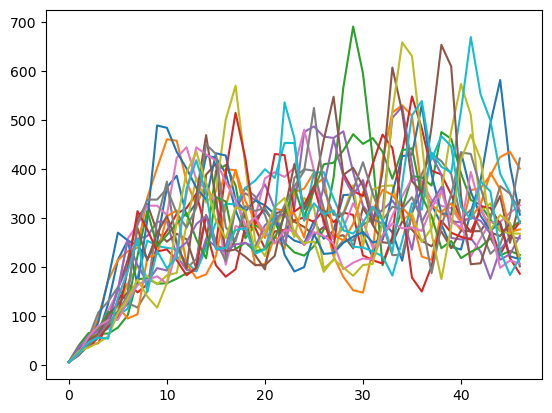

In [11]:
for huh, score_ in score.groupby("time.year"):
    plt.plot(score_.mean(["lon", "lat"]))

In [40]:
score.shape

(940, 31, 39)

In [13]:
import scoringrules as sr

In [ ]:
sr.crps_ensemble()